### CLDS Algoritmi: Greedy, VNS i Hybrid
Ova sveska implementira različite algoritme za pronalaženje najduže podsekvence u stringu koja:
- Pokriva sva slova iz alfabeta barem jednom.
- Pojavljuje se bar 2 puta u originalnom stringu kao subsequence.
- Svaka pozicija u originalnom stringu može se koristiti samo jednom po pojavljivanju.

In [28]:
# Uvoz potrebnih biblioteka
import os
import pandas as pd
import random
from itertools import permutations
import matplotlib.pyplot as plt

#### Brojanje nepreklapajućih pojavljivanja
Funkcija `count_nonoverlapping_occurrences` računa koliko puta se podsekvenca pojavljuje u stringu, tako da se svaki karakter koristi samo jednom po pojavljivanju.

In [29]:
def count_nonoverlapping_occurrences(sub, s):
    if not sub:
        return 0
    used = [False] * len(s)
    count = 0
    while True:
        i_sub = 0
        for i_s, c in enumerate(s):
            if i_sub >= len(sub):
                break
            if not used[i_s] and c == sub[i_sub]:
                i_sub += 1
                used[i_s] = True
        if i_sub < len(sub):
            break
        count += 1
    return count

#### Fitness funkcija
Funkcija `clds_fitness` vraća broj nepreklapajućih pojavljivanja podsekvence samo ako podsekvenca sadrži sva slova iz alfabeta.

In [30]:
def clds_fitness(sub, s, alphabet, d):
    # svaki simbol iz alfabetu mora biti prisutan, i max d po simbolu
    if not all(c in sub for c in alphabet):
        return 0
    if any(sub.count(c) > d for c in alphabet):
        return 0
    return count_nonoverlapping_occurrences(sub, s)

#### Greedy Basic (poboljšan)
Pokušava da pronađe minimalni komplet permutacija alfabeta i blago ga proširuje karakterom koji se najčešće pojavljuje. Cilj je da algoritam pronađe što bolju podsekvencu, ali ne preuzima sve što Advanced radi.

In [31]:
def greedy_basic(s, alphabet, d):
    counts = {c: s.count(c) for c in alphabet}
    min_complete = min(*counts.values(), d)
    if min_complete == 0:
        return "", 0

    best_sub = ""
    max_count = 0

    for perm in permutations(alphabet):
        candidate = ''.join(perm) * min_complete
        count = clds_fitness(candidate, s, alphabet, d)
        if count >= 2 and count > max_count:
            best_sub = candidate
            max_count = count

    if best_sub:
        most_common_char = max(counts, key=counts.get)
        extended = best_sub + most_common_char
        if clds_fitness(extended, s, alphabet, d) >= 2:
            best_sub = extended
            max_count = clds_fitness(extended, s, alphabet, d)

    return best_sub, max_count

#### Greedy Advanced
Probava sve permutacije i duže substringove kako bi pronašao najdužu moguću podsekvencu.

In [32]:
def greedy_advanced(s, alphabet, d):
    n = len(s)
    best_sub = ""
    max_count = 0
    max_len = 0

    counts = {c: s.count(c) for c in alphabet}
    min_complete = min(*counts.values(), d)

    for k in range(min_complete, 0, -1):
        for perm in permutations(alphabet):
            candidate = ''.join(perm) * k
            count = clds_fitness(candidate, s, alphabet, d)
            if count >= 2:
                if len(candidate) > max_len or (len(candidate) == max_len and count > max_count):
                    best_sub = candidate
                    max_len = len(candidate)
                    max_count = count
        if best_sub:
            return best_sub, max_count

    for length in range(len(alphabet), n + 1):
        for start in range(n - length + 1):
            sub = s[start:start+length]
            if all(c in sub for c in alphabet):
                count = clds_fitness(sub, s, alphabet, d)
                if count >= 2 and (length > max_len or (length == max_len and count > max_count)):
                    best_sub = sub
                    max_len = length
                    max_count = count
    return best_sub, max_count


#### VNS Basic (poboljšan)
Randomizovana pretraga oko početnog rešenja (od Greedy Basic) sa dodavanjem i uklanjanjem blokova.

In [33]:
def vns_basic(s, initial_solution, alphabet, d, max_iter=50):
    current, _ = initial_solution
    best = current
    best_count = clds_fitness(best, s, alphabet, d)

    for _ in range(max_iter):
        neighbor = list(best)

        if len(neighbor) + len(alphabet) <= len(s) and random.random() < 0.5:
            neighbor.extend(alphabet)

        if len(neighbor) >= 2 * len(alphabet) and random.random() < 0.3:
            neighbor = neighbor[:-len(alphabet)]

        if neighbor:
            pos = random.randint(0, len(neighbor)-1)
            neighbor[pos] = random.choice(alphabet)

        neighbor_str = ''.join(neighbor)
        count = clds_fitness(neighbor_str, s, alphabet, d)
        if count >= 2 and (count > best_count or len(neighbor_str) > len(best)):
            best = neighbor_str
            best_count = count

    return best, best_count

#### VNS Advanced
Naprednija varijanta VNS-a koja koristi i dodavanje/uklanjanje blokova i poboljšanu selekciju suseda.

In [34]:
def vns_advanced(s, initial_solution, alphabet, d, max_iter=100):
    current, current_count = initial_solution
    best = current
    best_count = current_count

    for _ in range(max_iter):
        neighbor = list(best)
        if len(neighbor) + len(alphabet) <= len(s):
            neighbor.extend(alphabet)
        if len(neighbor) >= 2 * len(alphabet) and random.random() < 0.4:
            neighbor = neighbor[:-len(alphabet)]
        if neighbor:
            pos = random.randint(0, len(neighbor)-1)
            neighbor[pos] = random.choice(alphabet)

        neighbor_str = ''.join(neighbor)
        count = clds_fitness(neighbor_str, s, alphabet, d)
        if count > best_count or (count == best_count and len(neighbor_str) > len(best)):
            best = neighbor_str
            best_count = count

    return best, best_count

#### Hybrid Advanced
Kombinacija Greedy Advanced i VNS Advanced.

In [35]:
def hybrid_advanced(s, alphabet, d):
    gb_adv_sub, gb_adv_count = greedy_advanced(s, alphabet, d)
    vb_adv_sub, vb_adv_count = vns_advanced(s, (gb_adv_sub, gb_adv_count), alphabet, d)
    return gb_adv_sub, gb_adv_count, vb_adv_sub, vb_adv_count

#### Upoređivanje algoritama
Prikaz rezultata svih algoritama po instancama.

In [36]:
def compare_algorithms(instances, alphabets, d):
    results = []
    for name, s in instances.items():
        alphabet = alphabets[name] if isinstance(alphabets, dict) else alphabets

        gb_sub, gb_count = greedy_basic(s, alphabet, d)
        ga_sub, ga_count = greedy_advanced(s, alphabet, d)
        vb_sub, vb_count = vns_basic(s, (gb_sub, gb_count), alphabet, d)
        va_sub, va_count = vns_advanced(s, (ga_sub, ga_count), alphabet, d)
        hy_sub, hy_count, hy_vb_sub, hy_vb_count = hybrid_advanced(s, alphabet, d)

        results.append({
            "Instance": name,
            "Greedy Basic": f"{gb_sub} ({gb_count})" if gb_count >= 2 else "",
            "Greedy Advanced": f"{ga_sub} ({ga_count})" if ga_count >= 2 else "",
            "VNS Basic": f"{vb_sub} ({vb_count})" if vb_count >= 2 else "",
            "VNS Advanced": f"{va_sub} ({va_count})" if va_count >= 2 else "",
            "Hybrid Advanced": f"{hy_vb_sub} ({hy_vb_count})" if hy_vb_count >= 2 else ""
        })
    return pd.DataFrame(results)

#### Test primeri za d = 1

In [37]:
# #### Pokretanje test primera sa ograničenjem d

# Definisanje instanci i alfabeta
instances_more = {
    "test1": "AABDBDD",
    "test2": "ABABABAB",
    "test3": "ACBDACBD",
    "test4": "AAAABBBBCCCCDDD",
    "test5": "ABDCABDCABDC",
    "test6": "AAAABBBBCCCCDDDABCD",
}
alphabets_more = {
    "test1": "ABD",
    "test2": "AB",
    "test3": "ABCD",
    "test4": "ABCD",
    "test5": "ABCD",
    "test6": "ABCD"
}

# Ograničenje d po simbolu
d = 1

# Pokretanje algoritama na ovim primerima
df_results = compare_algorithms(instances_more, alphabets_more, d=d)

# Prikaz rezultata
df_results


,Instance,Greedy Basic,Greedy Advanced,VNS Basic,VNS Advanced,Hybrid Advanced
0,test1,ABD (2),ABD (2),ABD (2),ABD (2),ABD (2)
1,test2,AB (4),AB (4),AB (4),AB (4),AB (4)
2,test3,ACBD (2),ACBD (2),ACBD (2),ACBD (2),ACBD (2)
3,test4,ABCD (3),ABCD (3),ABCD (3),ABCD (3),ABCD (3)
4,test5,ABDC (3),ABDC (3),ABDC (3),ABDC (3),ABDC (3)
5,test6,ABCD (4),ABCD (4),ABCD (4),ABCD (4),ABCD (4)


#### Test primeri za d = 2

#### CLDS Algoritmi za DNK sekvence
Ova sveska učitava DNK sekvence iz `data` foldera i upoređuje performanse algoritama nad instancama koristeći alfabet `"ACGT"`.

#### Učitavanje instanci iz `data` foldera i automatski izbor d
Svaki fajl u folderu predstavlja jednu DNK sekvencu.

In [39]:
data_folder = "data"
instances_data = {}

for filename in os.listdir(data_folder):
    if filename.endswith(".txt"):
        path = os.path.join(data_folder, filename)
        with open(path, "r") as f:
            sequence = f.read().strip().upper()
            instances_data[filename] = sequence

# DNK alfabet
alphabet_dna = "ACGT"

# Automatski odredi d = minimalni broj pojavljivanja simbola u stringu
d_values = {}
for name, seq in instances_data.items():
    counts = [seq.count(c) for c in alphabet_dna]
    d_values[name] = min(counts)  # tako da ne prelazi broj pojavljivanja


#### Pokretanje CLDS algoritama i snimanje rezultata u CSV
Koristimo prethodno definisane funkcije (`greedy_basic`, `greedy_advanced`, `vns_basic`, `vns_advanced`, `hybrid_advanced`) nad DNK instancama.

In [40]:
results_list = []
for name in instances_data.keys():
    df_temp = compare_algorithms(
        {name: instances_data[name]},
        {name: alphabet_dna},
        d=d_values[name]
    )
    results_list.append(df_temp)

df_all_custom_d = pd.concat(results_list, ignore_index=True)

# Snimanje u CSV
df_all_custom_d.to_csv("results.csv", index=False)
print("Rezultati su sačuvani u 'results.csv'")

Rezultati su sačuvani u 'results.csv'


#### Prikaz rezultata u Markdown tabeli

In [71]:
'''for idx, row in df_all_custom_d.iterrows():
    print(f"#### Instanca: {row['Instance']}")
    print(f"| Algoritam | Subsekvenca (broj ponavljanja) |")
    print(f"|-----------|-------------------------------|")
    for alg in ["Greedy Basic", "Greedy Advanced", "VNS Basic", "VNS Advanced", "Hybrid Advanced"]:
        print(f"| {alg} | {row[alg]} |")
    print("\n")'''

'for idx, row in df_all_custom_d.iterrows():\n    print(f"#### Instanca: {row[\'Instance\']}")\n    print(f"| Algoritam | Subsekvenca (broj ponavljanja) |")\n    print(f"|-----------|-------------------------------|")\n    for alg in ["Greedy Basic", "Greedy Advanced", "VNS Basic", "VNS Advanced", "Hybrid Advanced"]:\n        print(f"| {alg} | {row[alg]} |")\n    print("\n")'

#### Vizuelna analiza
Prikaz broja pojavljivanja najbolje podsekvence po algoritmu i instanci.


Prosečan score za large instance:
Hybrid Advanced_score    552.200
VNS Advanced_score       552.000
Greedy Advanced_score    548.000
VNS Basic_score           74.875
Greedy Basic_score         0.000
dtype: float64


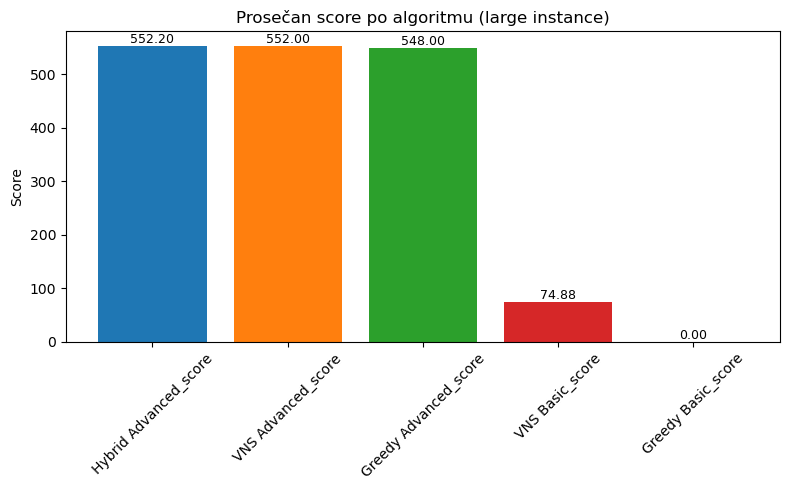


Prosečan score za medium instance:
VNS Advanced_score       116.200
Hybrid Advanced_score    116.000
Greedy Advanced_score    112.000
VNS Basic_score           56.975
Greedy Basic_score         0.000
dtype: float64


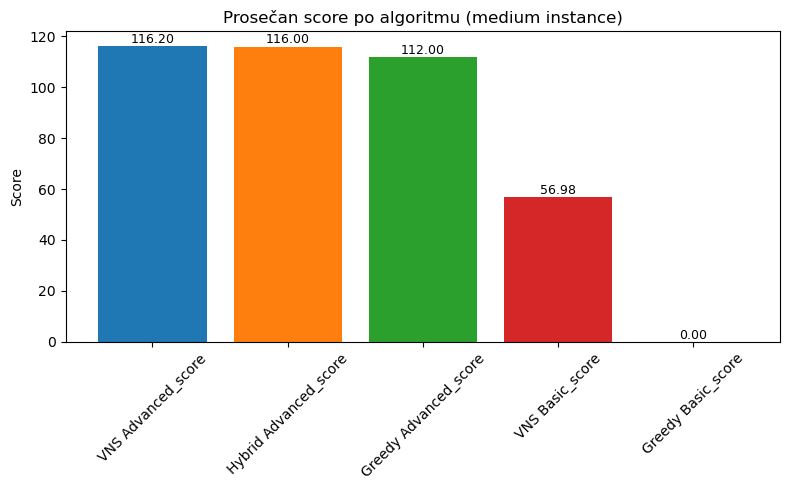


Prosečan score za small instance:
VNS Advanced_score       20.275
Hybrid Advanced_score    19.875
Greedy Advanced_score    18.850
VNS Basic_score          16.725
Greedy Basic_score        0.000
dtype: float64


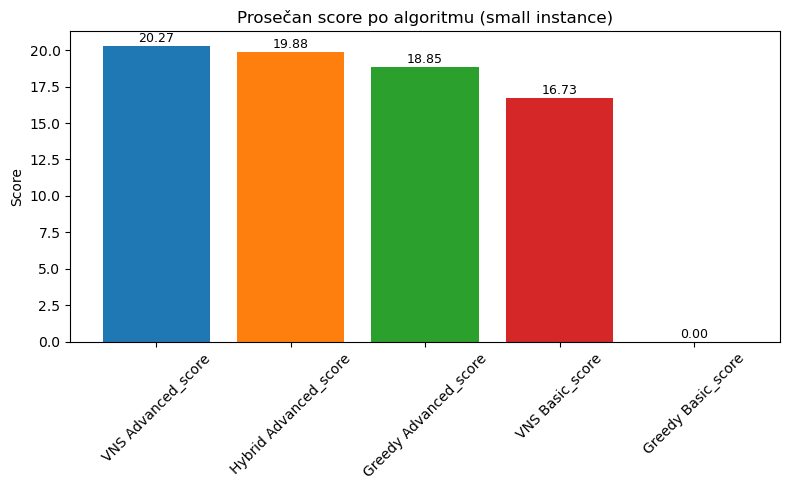


Prosečan score za xlarge instance:
Hybrid Advanced_score    1819.80
VNS Advanced_score       1818.80
Greedy Advanced_score    1815.20
VNS Basic_score           170.85
Greedy Basic_score          0.00
dtype: float64


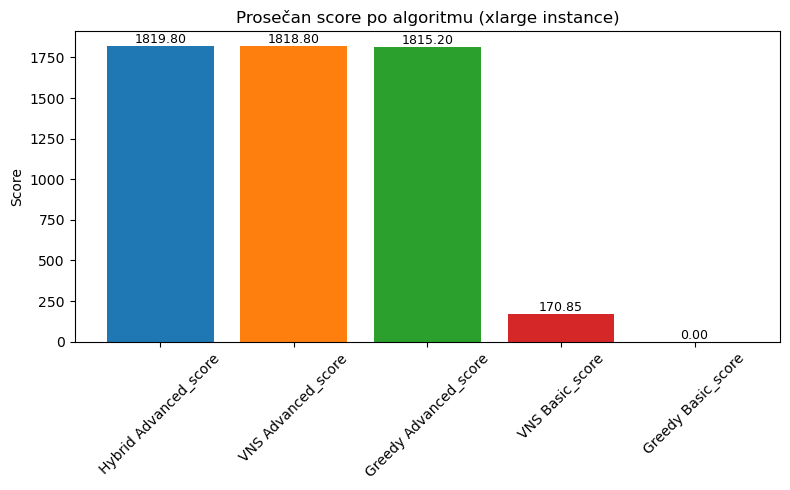

In [72]:
import pandas as pd
import re
import matplotlib.pyplot as plt

# --- Učitaj CSV ---
df = pd.read_csv("results.csv")

algorithms = ["Greedy Basic", "Greedy Advanced", "VNS Basic", "VNS Advanced", "Hybrid Advanced"]

# --- Funkcija za računanje score-a (duže sekvence nagrađuju više) ---
def effective_score(s):
    if pd.isna(s) or s.strip() == "":
        return 0
    match = re.match(r"(.*)\((\d+)\)", s.strip())
    if match:
        subseq, count = match.groups()
        subseq = subseq.strip()
        length = len(subseq)
        count = int(count)
        # nova logika: duže sekvence imaju veći score
        return length + 0.5 * count
    else:
        length = len(s.strip())
        return length + 0.5 * 1  # ako nema eksplicitnog ponavljanja, count=1

# --- Dodaj score kolone ---
for alg in algorithms:
    df[alg + "_score"] = df[alg].apply(effective_score)

# --- Odredi najbolji algoritam po instanci ---
def best_algorithm(row):
    best_val = -1
    best_alg = ""
    for alg in algorithms:
        val = row[alg + "_score"]
        if val > best_val:
            best_val = val
            best_alg = alg
    return best_alg

df["Best Algorithm"] = df.apply(best_algorithm, axis=1)

# --- Detektuj veličinu instance ---
def get_size(instance_name):
    if "small" in instance_name.lower():
        return "small"
    elif "medium" in instance_name.lower():
        return "medium"
    elif "large" in instance_name.lower() and "xlarge" not in instance_name.lower():
        return "large"
    elif "xlarge" in instance_name.lower():
        return "xlarge"
    else:
        return "unknown"

df["Size"] = df["Instance"].apply(get_size)

# --- Summary i bar chart po veličini ---
summary_tables = {}
for size in df["Size"].unique():
    subset = df[df["Size"] == size]
    summary = subset[[alg + "_score" for alg in algorithms]].mean().sort_values(ascending=False)
    summary_tables[size] = summary
    
    print(f"\nProsečan score za {size} instance:")
    print(summary)
    
    # Bar chart za tu veličinu
    plt.figure(figsize=(8,5))
    bars = plt.bar(summary.index, summary.values, color=plt.cm.tab10.colors[:len(summary)])
    plt.title(f"Prosečan score po algoritmu ({size} instance)")
    plt.ylabel("Score")
    plt.xticks(rotation=45)
    
    # Dodaj vrednosti iznad barova
    for i, val in enumerate(summary.values):
        plt.text(i, val + 0.05, f"{val:.2f}", ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()


Prosečan score za sve instance zajedno:
                       Average Score
Hybrid Advanced_score      626.96875
VNS Advanced_score         626.81875
Greedy Advanced_score      623.51250
VNS Basic_score             79.85625
Greedy Basic_score           0.00000


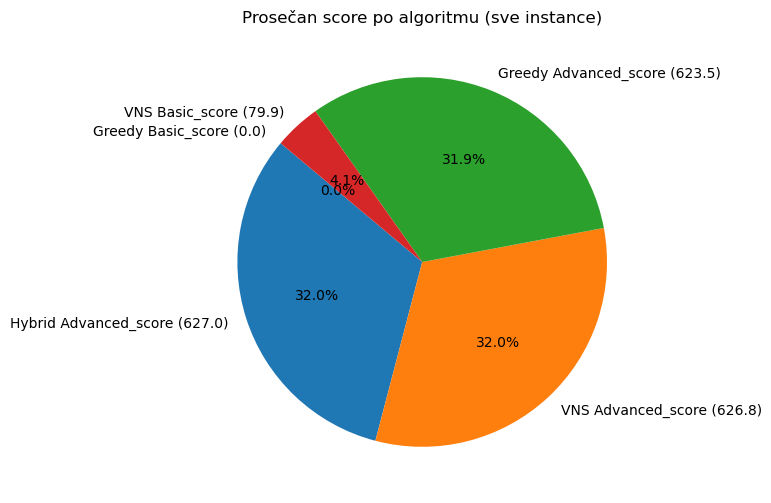

In [73]:
# --- Tabela sa prosečnim score-om svih algoritama ---
overall_summary = df[[alg + "_score" for alg in algorithms]].mean().sort_values(ascending=False)

print("Prosečan score za sve instance zajedno:")
print(overall_summary.to_frame(name="Average Score"))

# --- Pie chart prema prosečnom score-u ---
plt.figure(figsize=(6,6))
colors = plt.cm.tab10.colors[:len(overall_summary)]
plt.pie(overall_summary, 
        labels=[f"{alg} ({val:.1f})" for alg, val in overall_summary.items()],
        autopct="%1.1f%%", startangle=140, colors=colors)
plt.title("Prosečan score po algoritmu (sve instance)")
plt.show()


In [74]:
import pandas as pd

# Definisanje test instance i alfabeta
instances_more = {"test": "ABABABABABAB"}
alphabets_more = {"test": "AB"}

# Lista ograničenja d koje želimo testirati
d_values = [1, 2, 4]  # d, d+1, d+3 u tvom primeru

# Kreiranje praznog DataFrame-a za rezultate
all_results = pd.DataFrame()

# Iteracija kroz sve d vrednosti
for d_val in d_values:
    # Pokretanje algoritama za trenutnu d vrednost
    df_res = compare_algorithms(instances_more, alphabets_more, d=d_val)
    # Dodavanje kolone sa vrednošću d
    df_res['d'] = d_val
    # Dodavanje u ukupne rezultate
    all_results = pd.concat([all_results, df_res], ignore_index=True)

# Prikaz tabele sa svim rezultatima
all_results


,instance,algorithm,score,d
0,test,Greedy Basic,AB (1),1
1,test,Greedy Advanced,AB (1),1
2,test,VNS Basic,AB (1),1
3,test,VNS Advanced,AB (1),1
4,test,Hybrid Advanced,AB (1),1
5,test,Greedy Basic,AB (2),2
6,test,Greedy Advanced,AB (2),2
7,test,VNS Basic,AB (2),2
8,test,VNS Advanced,AB (2),2
9,test,Hybrid Advanced,AB (2),2
